# Online classification of the moons' dataset

In [1]:
import jax
import optax
import einops
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_moons

In [2]:
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as gf
from rebayes_mini.methods import replay_sgd as rsgd

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [5]:
n_samples = 200
data = make_moons(n_samples=n_samples, random_state=314, noise=0.15)
X, y = jax.tree_map(jnp.array, data)

key = jax.random.PRNGKey(314)

In [63]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = jnp.sin(x)
        # x = nn.relu(x)
        x = nn.Dense(50)(x)
        # x = nn.relu(x)
        x = jnp.sin(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)

In [64]:
agent = gf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)

# bel_init = agent.init_bel(params, cov=2.5)
bel_init = agent.init_bel(params, cov=0.5)
bel, bel_hist = agent.scan(bel_init, y, X, callbacks.get_updated_mean)

In [65]:
eta = agent.link_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5

In [66]:
(y == yhat.squeeze()).mean()

Array(0.965, dtype=float32)

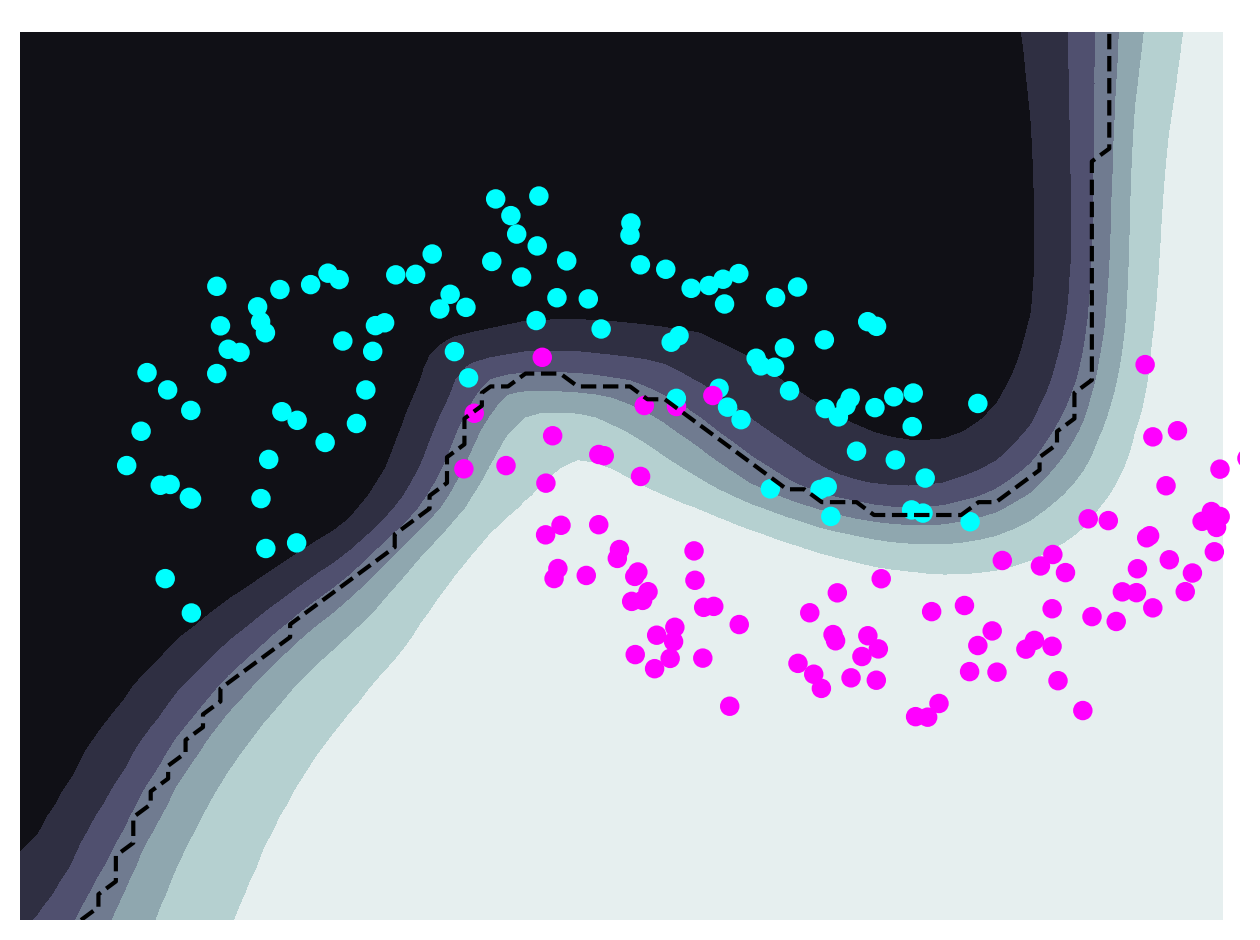

In [67]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_202632/3171874177.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


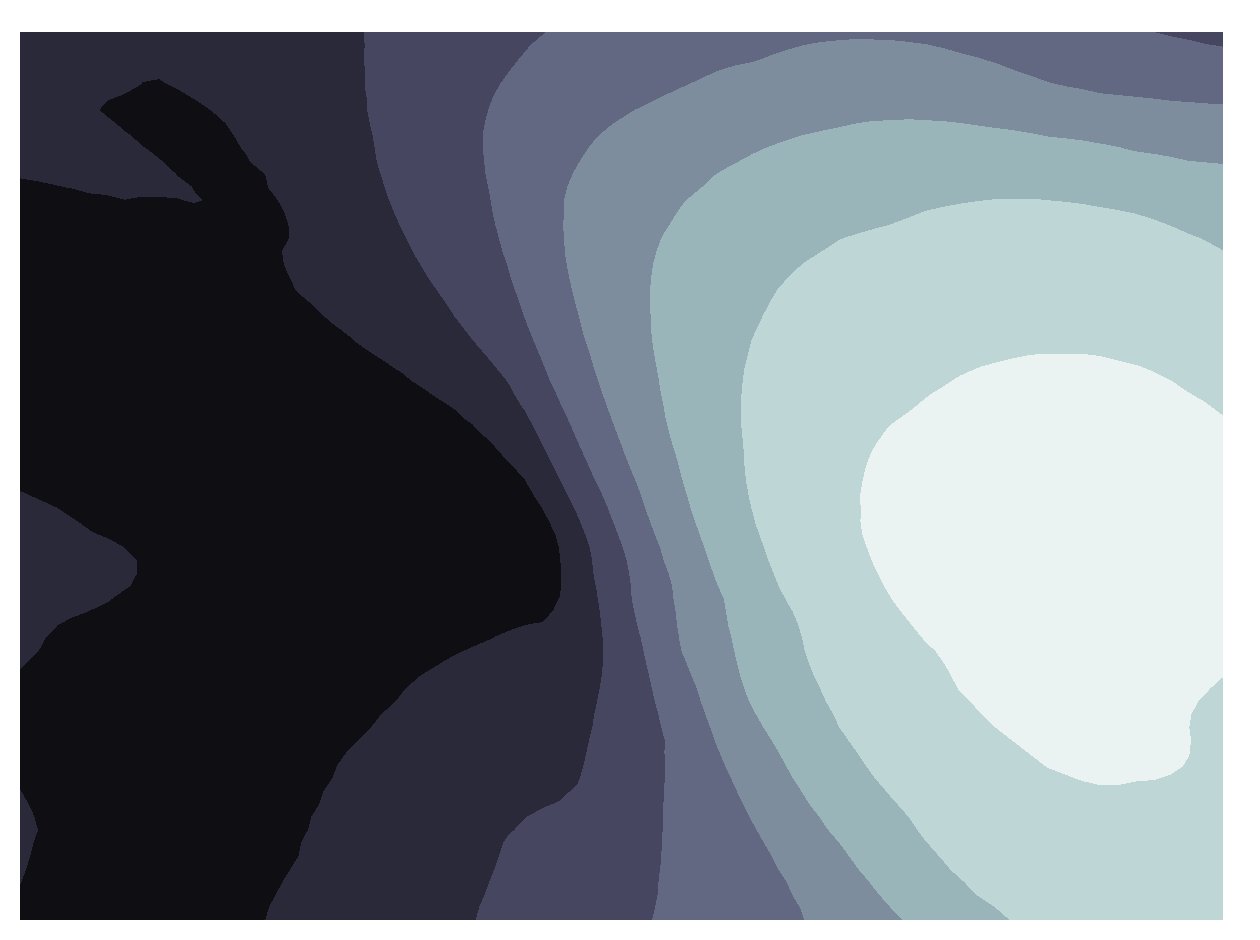

In [68]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    Z = np.array(agent.link_fn(bel, Xeval).squeeze())
    mean_Z = agent.mean(Z)
    plt.contourf(*XX, mean_Z, cmap="bone")
    plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
    plt.scatter(*np.array(X)[:t].T, c=y[:t], cmap="cool")
    plt.ylim(-1.5, 2)
    plt.xlim(-1.5, 2)
    plt.axis("off")
    plt.tight_layout()

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("bern-ekf.gif", fps=20)